# Anomaly Detection In Videos Surveillance Using Machine Learning

#### Why Don’t We Use Supervised Methods to Detect Anomalies?

Abnormal events are challenging to obtain due to their rarity.
There is a massive variety of abnormal events, and manually detecting and labeling such events is a difficult task that requires much manpower.

That's why we have to use unsupervised or semi-supervised methods like dictionary learning, Spatio-temporal features, and autoencoders. Unlike supervised methods, these methods only require unlabeled video footages that contain little or no abnormal events that are easy to obtain in real-world applications.

#### Autoencoders

Autoencoders are neural networks that are trained to reconstruct the input.

Two parts:
> The encoder: Capable of learning efficient representations of the input data (x) called the encoding f(x). The last layer of the encoder is called the bottleneck, which contains the input representation f(x).

> The decoder: produces a reconstruction of the input data r = g(f(x)) using the encoding in the bottleneck.

#### Approach
* It is all about the reconstruction error.

* We use an autoencoder to learn regularity in video sequences.

* The intuition is that the trained autoencoder will reconstruct regular video sequences with low error but it will not accurately reconstruct motions in irregular video sequences.



#### UCSD anomaly detection dataset

* It only contains videos acquired with a camera mounted at an elevation, overlooking a pedestrian walkway.

* Abnormal events are due to either:
    1. Non-pedestrian entities in the walkway, like bikers, skaters, and small carts.
    2. Unusual pedestrian motion patterns like people walking across a walkway or at the grass surrounding it.


[Download](http://www.svcl.ucsd.edu/projects/anomaly/dataset.htm)

#### Mounting Drive for dataset and other purposes 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 #!pip install keras-layer-normalization

#### Setting Up

In [ ]:
class Config:
  DATASET_PATH ="/content/drive/MyDrive/Sem-6/SGP/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  SINGLE_TEST_PATH = "/content/drive/MyDrive/Sem-6/SGP/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/content/drive/MyDrive/Sem-6/SGP/model.hdf5"

#### Get Frames

In [ ]:
import cv2
from google.colab import files
import numpy as np
import os
from os.path import isfile, join

In [ ]:
vidcap = cv2.VideoCapture('Enter Video Path')

In [ ]:
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/drive/MyDrive/Sem-6/SGP/frames/"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

In [ ]:
sec = 0
frameRate = 0.3 #it will capture image in each 0.3 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

#### Preparing The Training Set

The training set consists of sequences of regular video frames; the model will be trained to reconstruct these sequences. So, let’s get the data ready to feed our model by following these three steps:
1. Divide the training video frames into temporal sequences, each of size 10 using the sliding window technique.
2. Resize each frame to 256 × 256 to ensure that input images have the same resolution.
3. Scale the pixels values between 0 and 1 by dividing each pixel by 256.

For generating more number of training data we are going to perform [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation). To generate more training sequences, we concatenate frames with various skipping strides. For example, the first stride-1 sequence is made up of frames (1, 2, 3, 4, 5, 6, 7, 8, 9, 10), whereas the first stride-2 sequence consists of frames (1, 3, 5, 7, 9, 11, 13, 15, 17, 19).

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
# for data augmenting purposes
def get_clips_by_stride(stride, frames_list, sequence_size):
    # stride : The desired distance between two consecutive frames
    # frames_list : A list of sorted frames of shape 256 X 256
    # sequence_size: The size of the desired LSTM sequence

    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                # checking the image formate is .tif or not
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    # resize image to 256*256
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    # scaling pixel between 0 and 1.
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips   

#### Building And Training The Model
> We will use Keras to build our convolutional LSTM autoencoder. we will train the model to reconstruct the regular events.

> To build the autoencoder, we should define the encoder and the decoder. The encoder accepts as input a sequence of frames in chronological order, and it consists of two parts: the spatial encoder and the temporal encoder. The encoded features of the sequence that comes out of the spatial encoder are fed into the temporal encoder for motion encoding.

> The decoder mirrors the encoder to reconstruct the video sequence

**Model**

* Convolutional LSTM layers
  - For general purposes sequence modeling, LSTM as a particular RNN structure has proven stable and robust for preserving long-range dependencies.
Here we used convolutional LSTM layers instead of fully connected LSTM layers because FC-LSTM layers do not keep the spatial data very well because of its usage of full connections in input-to-state and state-to-state transitions in which no spatial information is encoded.
* Purpose of Layer Normalization
  - Training deep neural networks is computationally expensive. One way to reduce the training time is to normalize the activities of the neurons using Layer Normalization. 


In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    # here we are checking that the pre-trained model exits or not. If yes then we'll use it otherwise we'll train the models and store it somewhere.
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

#### Single Test Data
The first step is to get the test data. We will test each testing video individually. The value of Config.SINGLE_TEST_PATH determines which one will be used.

In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


#### Testing Model
Each testing video has 200 frames. We use the sliding window technique to get all the consecutive 10-frames sequences. In other words, for each t between 0 and 190, we calculate the regularity score Sr(t) of the sequence that starts at frame (t) and ends at frame (t+9).

In [ ]:
# fetch model
model = get_model(False)
print("Model : ", model)

Model :  <keras.engine.sequential.Sequential object at 0x7fd04fe9c5d0>


In [ ]:
# test data 
test = get_single_test() 
print("\nTest Video Shape : ", test.shape) 
sz = test.shape[0] - 10 + 1 
sequences = np.zeros((sz, 10, 256, 256, 1))


Test Video Shape :  (200, 256, 256, 1)


In [ ]:
# apply the sliding window technique to get the sequences
for i in range(0, sz):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
        clip[j] = test[i + j, :, :, :]
    sequences[i] = clip
print("\nGot data", sequences.shape)


Got data (191, 10, 256, 256, 1)


In [ ]:
# get the reconstruction cost of all the sequences
reconstructed_sequences = model.predict(sequences,batch_size=4)
# print("\nreconstructed_sequences", reconstructed_sequences)

In [ ]:
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
# print("\nsequences_reconstruction_cost", sequences_reconstruction_cost)

In [ ]:
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
# print("\nsa", sa)
sr = 1.0 - sa
print("\nsr", sr)

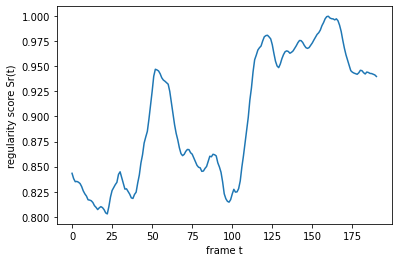

In [ ]:
# plot the regularity scores
print()
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def evaluate():
    # fetch model
    model = get_model(False)
    print("Model : ", model)
    
    # test data
    test = get_single_test()
    print("\nTest Video Shape : ", test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    print("\nGot data", sequences.shape)

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    # print("\nreconstructed_sequences", reconstructed_sequences)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    # print("\nsequences_reconstruction_cost", sequences_reconstruction_cost)
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    # print("\nsa", sa)
    sr = 1.0 - sa
    test_sr = sr
    # print("\nsr", sr)
    # plot the regularity scores
    print()
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [ ]:
evaluate()

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


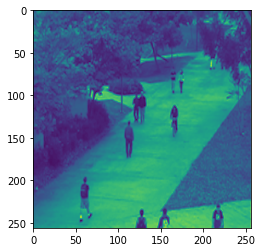

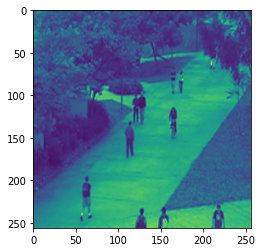

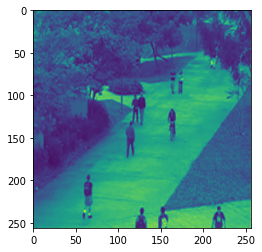

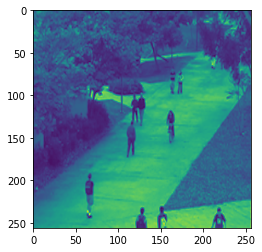

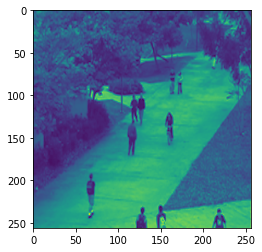

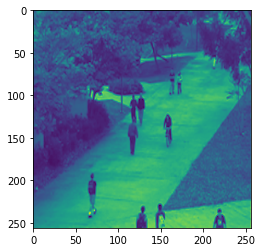

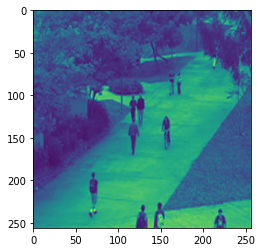

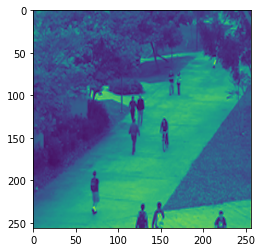

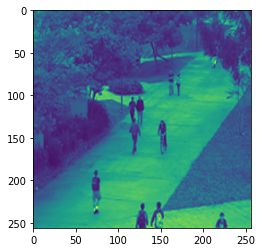

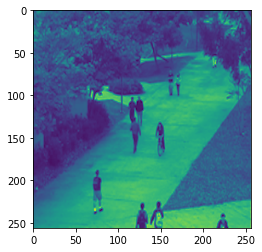

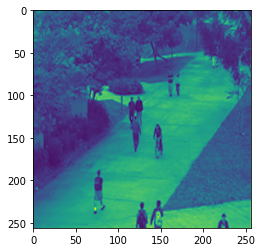

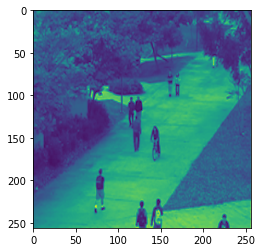

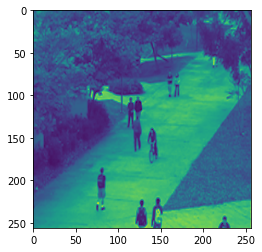

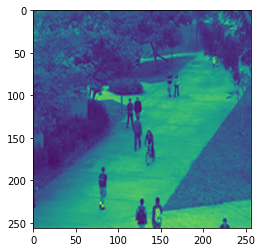

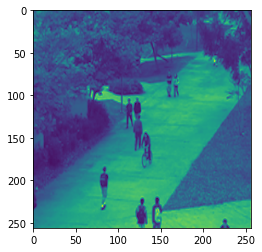

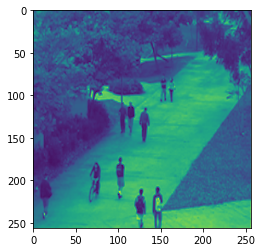

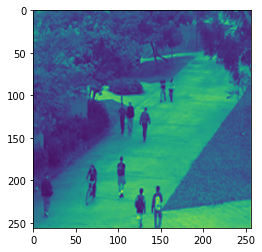

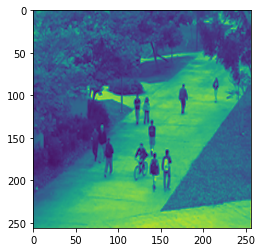

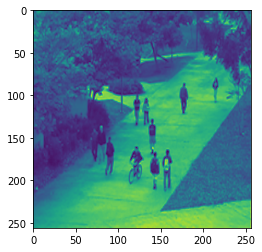

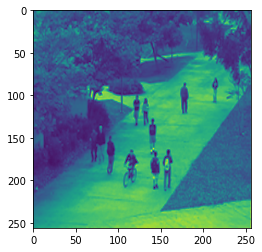

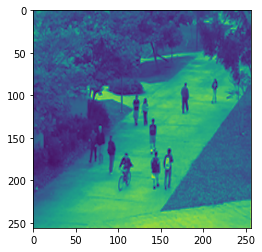

In [ ]:
from PIL import Image as im
import rasterio
from rasterio.plot import show

for i in range(0,190):
  if(sr[i] < 0.82):
    array = np.reshape(test[i], (256,256))
    data = im.fromarray(array)
    data.save('anomaly_tested'+str(i)+'.tif')
    fp = r'anomaly_tested'+str(i)+'.tif'
    img = rasterio.open(fp)
    show(img)